# DETECTION MODEL TRAINING

- this file shows how we have trained our model
- if you just want to test our model refer `detector_testing.ipynb`

## GETTING THE DATASET

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


`x_ultimate.zip` is the COCO 2017 test dataset images cropped to 256x256 and pixelated

In [ ]:
!unzip /content/drive/MyDrive/ULTIMATE_DATASET/x_ultimate.zip

In [4]:
import os

print(len(os.listdir('./x_ultimate/')))

80820


upgrading these libraries

In [ ]:
%pip install --upgrade pip
%pip install --upgrade tensorflow
%pip install --upgrade scikit-learn
%pip install --upgrade pydot
%pip install --upgrade matplotlib

## IN CASE YOU ARE FACING ISSUES WHILE LOADING MODELS OR IMPORTING LIBRARIES YOU CAN
## USE THE VERSIONS OF THESE LIBRARIES ON WHICH OUR MODEL WAS CREATED

# %pip install --upgrade pip==24.1.1
# %pip install --upgrade ipykernel==5.5.6
# %pip install --upgrade numpy==1.25.2
# %pip install --upgrade pandas==2.0.3
# %pip install --upgrade tensorflow==2.16.2
# %pip install --upgrade keras==3.4.1
# %pip install --upgrade scikit-learn==1.5.0
# %pip install --upgrade matplotlib==3.9.0
# %pip install --upgrade pydot==2.0.0

In [5]:
import os
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt

getting the `image_paths` and `image_labels` as lists

In [6]:
NON_PIXELATED = 0
PIXELATED = 1
class_names = ['Non-Pixelated', 'Pixelated']

image_dir = './x_ultimate/'
image_basenames = sorted(os.listdir(image_dir))

image_paths = [os.path.join(image_dir, bname) for bname in image_basenames]
image_labels = [NON_PIXELATED if bname.split('_')[1][0] == 'r' else PIXELATED for bname in image_basenames]

total_size = len(image_paths)

print(len(image_paths))
print(len(image_labels))

print(image_paths[-5:])
print(image_labels[-5:])

80820
80820
['./x_ultimate/300021196t_d3.png', './x_ultimate/300021197o_real.png', './x_ultimate/300021198t_d8.png', './x_ultimate/300021199o_real.png', './x_ultimate/300021200t_d4.png']
[1, 0, 1, 0, 1]


function to load the image and preprocess it to hqave values in [0,1]

In [7]:
@tf.function
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.float32, expand_animations=False)
    return image

@tf.function
def load_data(image_path, image_label):
    return load_image(image_path), image_label

creating the train, test, validation datasets and batching it

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

train_val_size = int(0.85 * total_size)
train_size     = int(0.70 * total_size)

train_val_dataset = dataset.take(train_val_size)
test_dataset      = dataset.skip(train_val_size)

train_dataset = train_val_dataset.take(train_size)
val_dataset   = train_val_dataset.skip(train_size)

batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size=dataset.cardinality(), seed=61, reshuffle_each_iteration=True)\
                             .map(load_data, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                             .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset   =   val_dataset.shuffle(buffer_size=dataset.cardinality(), seed=62, reshuffle_each_iteration=True)\
                             .map(load_data, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                             .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset  =  test_dataset.shuffle(buffer_size=dataset.cardinality(), seed=63, reshuffle_each_iteration=True)\
                             .map(load_data, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                             .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

print(train_dataset.cardinality().numpy(), val_dataset.cardinality().numpy(), test_dataset.cardinality().numpy())

884 190 190


this is the full model architecture, refer to the `detector_005_1.png` for a visual description

In [9]:
def translate_encoder(block_id, x, filters, kernel_size=3, activation='relu'):
  x = tfl.SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same', activation=None, use_bias=True, name=f'separable_convolution_{block_id}')(x)
  x = tfl.BatchNormalization(epsilon=1e-3, momentum = 0.999, name=f'batch_normalization_{block_id}')(x)
  return tfl.Activation(activation=activation, name=f'activation_{block_id}')(x)

def encoder_block(block_id, x, filters, kernel_size=3, strides=2, padding='same', activation='relu'):
  x = tfl.SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=None, use_bias=True, name=f'separable_convolution_{block_id}')(x)
  x = tfl.BatchNormalization(epsilon=1e-3, momentum = 0.999, name=f'batch_normalization_{block_id}')(x)
  return tfl.Activation(activation=activation, name=f'activation_{block_id}')(x)

def classifier_block(block_id, x, units=64, activation='relu'):
  x = tfl.GlobalMaxPooling2D(name=f'global_max_pooling_{block_id}')(x)
  x = tfl.Dense(units=units, activation=activation, name=f'dense_1_{block_id}')(x)
  return tfl.Dense(units=1, name=f'dense_2_{block_id}')(x)

input_shape = (None, None, 3)
inputs = tfk.Input(input_shape, name='input_layer')

# encoder
t0 = translate_encoder(1, inputs, 8)
t1 = translate_encoder(2, t0, 16)
e0 = encoder_block(3, t1, 32)
e1 = encoder_block(4, e0, 64)
e2 = encoder_block(5, e1, 128)
e3 = encoder_block(6, e2, 256)
encoder_outputs = encoder_block(7, e3, 512)

# classifier
classifier_output = classifier_block('cl', encoder_outputs)

detector = tfk.Model(inputs, classifier_output, name='detector')

detector.summary()
# tfk.utils.plot_model(detector, to_file='/content/drive/MyDrive/DETECTOR_005/detector_005_1.png', show_layer_activations=True, show_layer_names=True, show_shapes=True, show_trainable=True)

Model: "detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_convolution_1              │ (None, None, None, 8)       │              59 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, None, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, None, None, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_convolution_2              │ (None, None, None, 16)      │             216 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, None, None, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, None, None, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_convolution_3              │ (None, None, None, 32)      │             688 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, None, None, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_convolution_4              │ (None, None, None, 64)      │           2,400 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, None, None, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_convolution_5              │ (None, None, None, 128)     │           8,896 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, None, None, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 217,284 (848.77 KB)

 Trainable params: 215,252 (840.83 KB)

 Non-trainable params: 2,032 (7.94 KB)

In [11]:
detector.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
    loss=tfk.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tfk.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
        tfk.metrics.Precision(thresholds=0.0, name='precision'),
        tfk.metrics.Recall(thresholds=0.0, name='recall')
        ]
    )

testing the model before training

In [ ]:
# before training
loss0, accuracy0, precision0, recall0 = detector.evaluate(test_dataset)

190/190 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.4084 - loss: 0.6931 - precision: 0.5916 - recall: 1.0000


In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=5,
)

## training for 25 epochs

In [ ]:
history = detector.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    initial_epoch=0,
                    callbacks=[early_stopping])

detector.save('/content/drive/MyDrive/DETECTOR_005/detector_005_1_25.keras')
detector.save('/content/drive/MyDrive/DETECTOR_005/detector_005_1_25.h5')

Epoch 1/25
884/884 ━━━━━━━━━━━━━━━━━━━━ 364s 383ms/step - accuracy: 0.6369 - loss: 0.6865 - precision: 0.6929 - recall: 0.8218 - val_accuracy: 0.4014 - val_loss: 0.6897 - val_precision: 0.5986 - val_recall: 1.0000
Epoch 2/25
884/884 ━━━━━━━━━━━━━━━━━━━━ 262s 296ms/step - accuracy: 0.7513 - loss: 0.5176 - precision: 0.7669 - recall: 0.8355 - val_accuracy: 0.4014 - val_loss: 0.6852 - val_precision: 0.5986 - val_recall: 1.0000
Epoch 3/25
884/884 ━━━━━━━━━━━━━━━━━━━━ 334s 310ms/step - accuracy: 0.7615 - loss: 0.4898 - precision: 0.7876 - recall: 0.8301 - val_accuracy: 0.4014 - val_loss: 0.6784 - val_precision: 0.5986 - val_recall: 1.0000
Epoch 4/25
884/884 ━━━━━━━━━━━━━━━━━━━━ 262s 296ms/step - accuracy: 0.7784 - loss: 0.4600 - precision: 0.8079 - recall: 0.8345 - val_accuracy: 0.4014 - val_loss: 0.6749 - val_precision: 0.5986 - val_recall: 1.0000
Epoch 5/25
884/884 ━━━━━━━━━━━━━━━━━━━━ 304s 343ms/step - accuracy: 0.7916 - loss: 0.4320 - precision: 0.8233 - recall: 0.8411 - val_accuracy: 0

## RESULTS AFTER 25 EPOCHS

In [ ]:
def history_results(history, par1='loss', par2='val_loss', title='Loss'):
    plt.plot(history.history[par1])
    plt.plot(history.history[par2])
    plt.title(title)
    plt.ylabel(par1)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()
    return

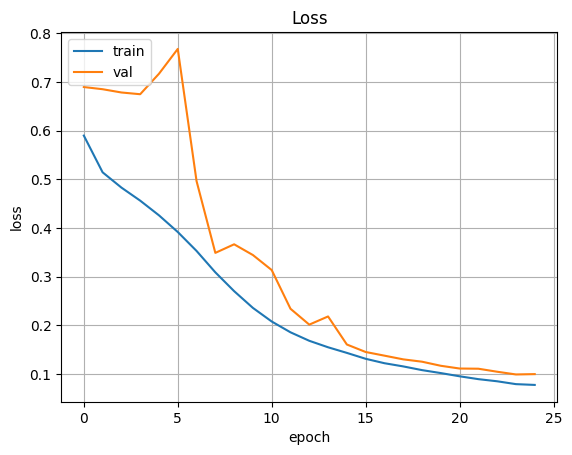

In [ ]:
history_results(history)

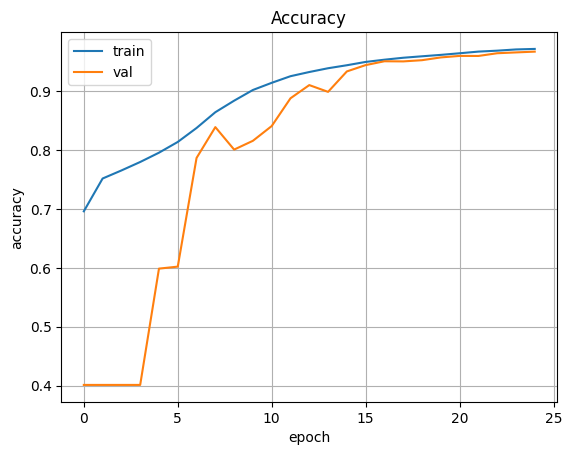

In [ ]:
history_results(history, 'accuracy', 'val_accuracy', 'Accuracy')

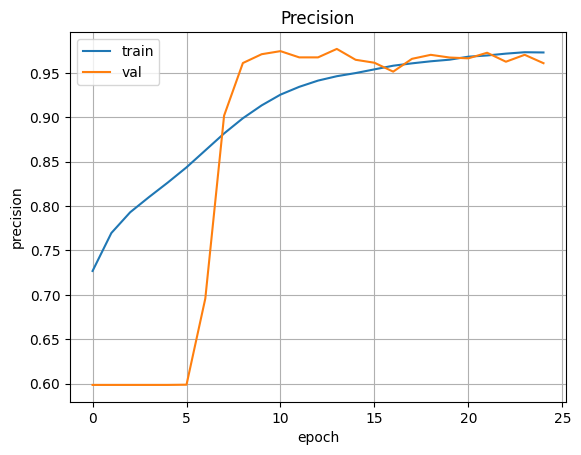

In [ ]:
history_results(history, 'precision', 'val_precision', 'Precision')

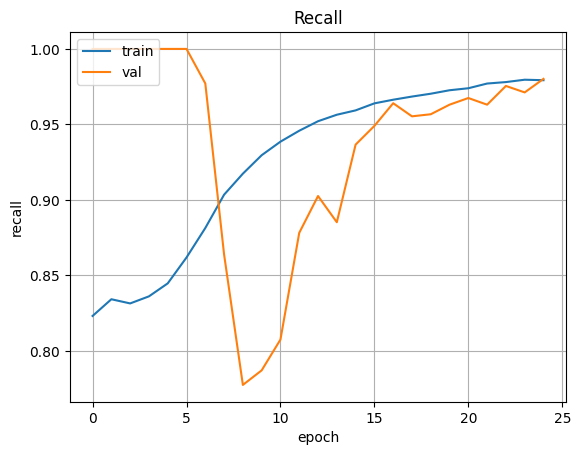

In [ ]:
history_results(history, 'recall', 'val_recall', 'Recall')

In [ ]:
# before training
print(loss0, accuracy0, precision0, recall0)

190/190 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.4084 - loss: 0.6931 - precision: 0.5916 - recall: 1.0000


In [ ]:
# after 25 epochs
loss_test, accuracy_test, precision_test, recall_test = detector.evaluate(test_dataset)

190/190 ━━━━━━━━━━━━━━━━━━━━ 49s 257ms/step - accuracy: 0.9606 - loss: 0.1174 - precision: 0.9585 - recall: 0.9785


## TRAINING ANOTHER 25 EPOCHS

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=5,
)

In [ ]:
history = detector.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    initial_epoch=25,
                    callbacks=[early_stopping])

detector.save('/content/drive/MyDrive/DETECTOR_005/detector_005_1_50.keras')
detector.save('/content/drive/MyDrive/DETECTOR_005/detector_005_1_50.h5')

Epoch 26/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 388s 404ms/step - accuracy: 0.9708 - loss: 0.0747 - precision: 0.9739 - recall: 0.9824 - val_accuracy: 0.9682 - val_loss: 0.0926 - val_precision: 0.9702 - val_recall: 0.9749
Epoch 27/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 268s 303ms/step - accuracy: 0.9760 - loss: 0.0660 - precision: 0.9779 - recall: 0.9836 - val_accuracy: 0.9685 - val_loss: 0.0910 - val_precision: 0.9690 - val_recall: 0.9785
Epoch 28/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 328s 309ms/step - accuracy: 0.9766 - loss: 0.0642 - precision: 0.9781 - recall: 0.9850 - val_accuracy: 0.9687 - val_loss: 0.0894 - val_precision: 0.9785 - val_recall: 0.9711
Epoch 29/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 300s 339ms/step - accuracy: 0.9778 - loss: 0.0623 - precision: 0.9793 - recall: 0.9854 - val_accuracy: 0.9696 - val_loss: 0.0852 - val_precision: 0.9765 - val_recall: 0.9745
Epoch 30/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 321s 338ms/step - accuracy: 0.9794 - loss: 0.0572 - precision: 0.9805 - recall: 0.9862 - val_accura

## RESULTS AFTER 50 EPOCHS

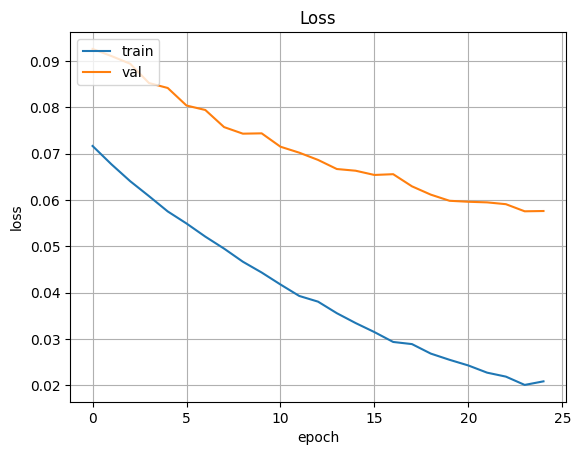

In [ ]:
history_results(history)

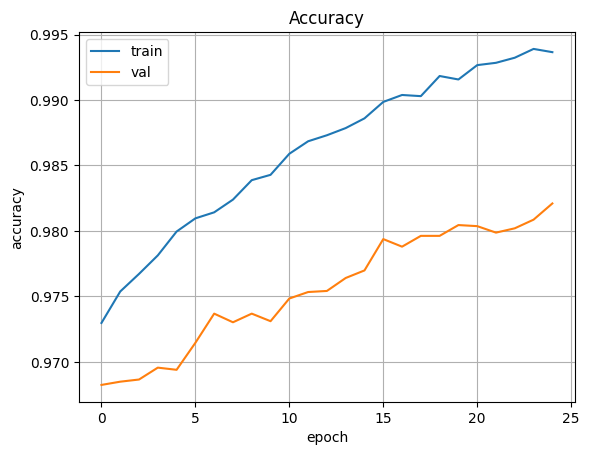

In [ ]:
history_results(history, 'accuracy', 'val_accuracy', 'Accuracy')

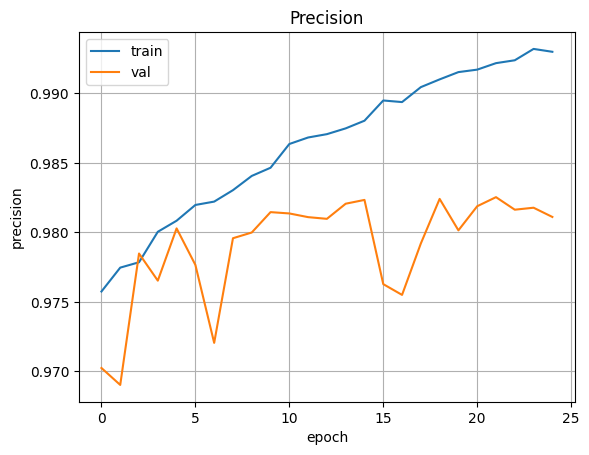

In [ ]:
history_results(history, 'precision', 'val_precision', 'Precision')

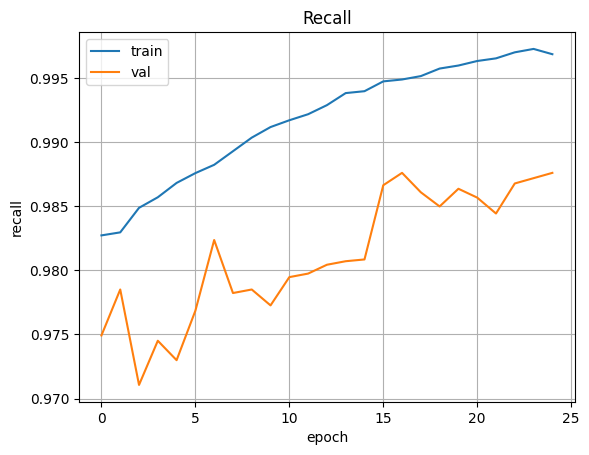

In [ ]:
history_results(history, 'recall', 'val_recall', 'Recall')

In [ ]:
# before training
print(loss0, accuracy0, precision0, recall0)

190/190 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.4084 - loss: 0.6931 - precision: 0.5916 - recall: 1.0000


In [ ]:
# after 25 epochs
print(loss_test, accuracy_test, precision_test, recall_test)

190/190 ━━━━━━━━━━━━━━━━━━━━ 49s 257ms/step - accuracy: 0.9606 - loss: 0.1174 - precision: 0.9585 - recall: 0.9785


In [ ]:
# after 50 epochs
loss_test, accuracy_test, precision_test, recall_test = detector.evaluate(test_dataset)

190/190 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.9753 - loss: 0.0656 - precision: 0.9776 - recall: 0.9853


## TESTING

Now we are testing our model on fully unseen 1080p pixelated images
- `un_mod_ultimate.zip` is a subset (1028 images) of unsplash dataset, pixelated and cropped to 1920x1080

In [ ]:
!unzip /content/drive/MyDrive/ULTIMATE_DATASET/un_mod_ultimate.zip

In [ ]:
!mkdir un_mod_ultimate

!mv /content/x8/* /content/un_mod_ultimate/

In [ ]:
len(os.listdir('./un_mod_ultimate/'))

1028

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
BATCH_SIZE = 4 # use  1 if test images are of different sizes
                # use >1 if all the images are of same size


NON_PIXELATED = 0
PIXELATED = 1
class_names = ['Non-Pixelated', 'Pixelated']

In [ ]:
# implement the cell to get the image_paths and image_labels lists
# image_paths : this contains all the image paths eg. ['./path/to/image1.jpg', './path/to/image2.png', ...]
# image_labels: this containts the labels (same type as PIXELATED, NON_PIXELATED variables) eg. [True, False, False, ...]
# save all the test images in a single image_dir

image_dir = './un_mod_ultimate/'
image_basenames = sorted(os.listdir(image_dir))

image_paths = [os.path.join(image_dir, bname) for bname in image_basenames]
image_labels = [NON_PIXELATED if bname.split('_')[1][0] == 'r' else PIXELATED for bname in image_basenames]


# check if your implementation working correctly

print(len(image_paths))
print(len(image_labels))

print(image_paths[-10:])
print(image_labels[-10:])

1028
1028
['./un_mod_ultimate/800001019_d3.png', './un_mod_ultimate/800001020_d8.png', './un_mod_ultimate/800001021_d2.png', './un_mod_ultimate/800001022_real.png', './un_mod_ultimate/800001023_real.png', './un_mod_ultimate/800001024_d6.png', './un_mod_ultimate/800001025_d3.png', './un_mod_ultimate/800001026_j10.png', './un_mod_ultimate/800001027_d6.png', './un_mod_ultimate/800001028_d2.png']
[1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


In [ ]:
# this function loads the image from corresponding image_path and preprocesses it to have:
# - pixel values in [0,1], float32 type, 3 channels
# - pad to have height, width as multiple of 64 (this is required due to model architecture)

@tf.function
def load_process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False, dtype=tf.float32)

    shape = tf.shape(img)
    height, width = shape[0], shape[1]
    padding_width  = ((width  + 63) // 64) * 64 - width
    padding_height = ((height + 63) // 64) * 64 - height
    left  = padding_width  // 2
    upper = padding_height // 2

    return tf.image.pad_to_bounding_box(img, upper, left, height + padding_height, width + padding_width)


# create the dataset, batch, prefetch object

custom_test_dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(load_process_image, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                                                                     .batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)\
                                                                     .prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
predictions = detector.predict(custom_test_dataset)
pred_labels = tf.where(predictions < 0, NON_PIXELATED, PIXELATED).numpy().flatten()
true_labels = np.array(image_labels)

257/257 ━━━━━━━━━━━━━━━━━━━━ 114s 374ms/step



Accuracy: 0.8716

Class Names    Precision  Recall  F1-Score
--------------------------------------------
Non-Pixelated    0.8096   0.8781   0.8425
Pixelated        0.9172   0.8674   0.8916


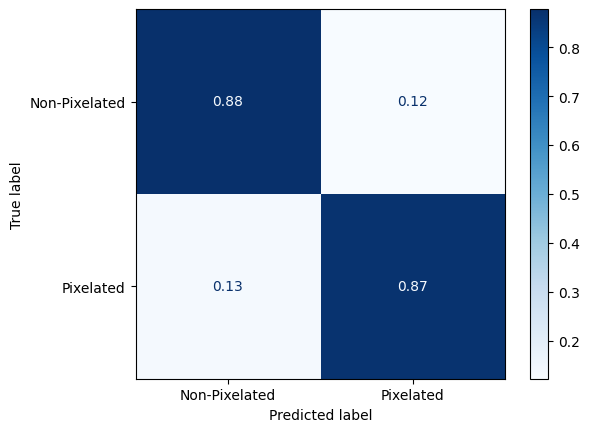

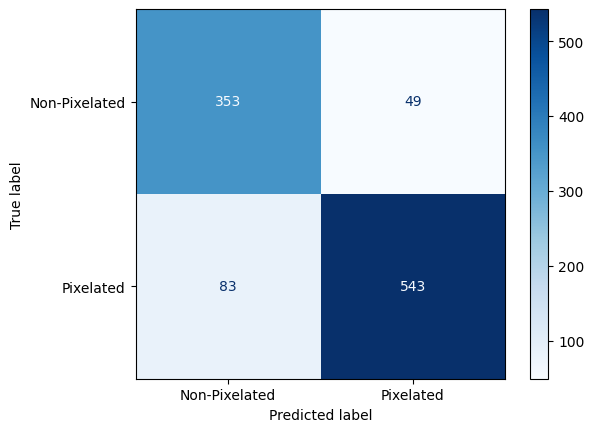

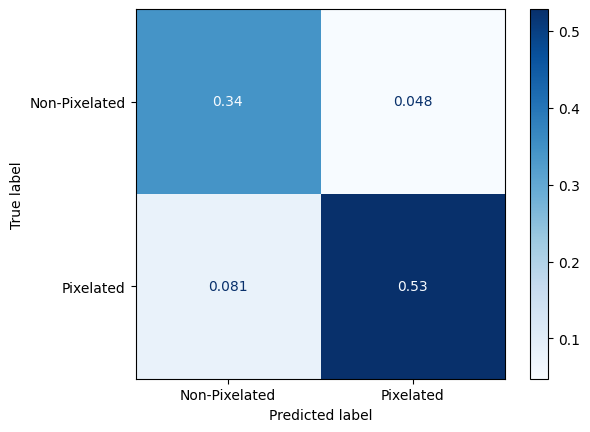

In [ ]:
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average=None, zero_division=0.0)
recall = recall_score(true_labels, pred_labels, average=None, zero_division=0.0)
f1 = f1_score(true_labels, pred_labels, average=None)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nClass Names    Precision  Recall  F1-Score")
print("--------------------------------------------")
for class_name, p, r, f in zip(class_names, precision, recall, f1):
  print(f"{class_name:15}  {p:.4f}   {r:.4f}   {f:.4f}")

_ = ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, display_labels=class_names, normalize='true', cmap='Blues')
_ = ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, display_labels=class_names, normalize=None,   cmap='Blues')
_ = ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, display_labels=class_names, normalize='all',  cmap='Blues')

In [ ]:
from google.colab import runtime
runtime.unassign()